In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate Uniform Rectangular Array

In [2]:
def get_URA(el, az, Lx, Ly, N, sVar=10, phi=None, dx=None, dy=None, f0=2.4e9, r0=[0,0,0]):
    # Prepare inputs
    el = np.deg2rad(el)
    az = np.deg2rad(az)
    lambd = 300e6 / f0
    if dx is None or dy is None:
        dx = lambd / 2
        dy = lambd / 2
    M = len(el)

    # Generate URA positions
    rxy = np.zeros((3, Lx, Ly))
    rxy[2, :] =+ r0[2]
    for x in range(Lx):
        for y in range(Ly):
            rxy[0, x, y] = x * dx + r0[0]
            rxy[1, x, y] = y * dy + r0[1]
    rxy = rxy.reshape(3, Lx * Ly)

    # Generate signal s(t)
    t_vec = np.linspace(start=1, stop=N, num=N)
    if phi is None:
        phi = np.random.uniform(low=0, high=2*np.pi, size=(M, N))
    s = np.sqrt(sVar) * np.exp(1j * phi)

    # Generate steering matrix A(el, az)
    A = np.zeros((Lx * Ly, M), dtype=complex)
    for m in range(M):

        e = np.array([np.sin(el[m]) * np.cos(az[m]), 
                      np.sin(el[m]) * np.sin(az[m]), 
                      np.cos(el[m])])

        for l in range(Lx * Ly):

            A[l, m] = np.exp(2j * np.pi / lambd * e @ rxy[:,l])

    x = A @ s

    return x, rxy

Noise function

In [3]:
def get_noise(x, SNR_dB=5):
    L, N = x.shape
    SNR = 10.0**(SNR_dB / 10.0) # Desired linear SNR
    xVar = x.var() # Power of signal
    nVar = xVar / SNR # Desired power of noise
    n = np.random.normal(0, np.sqrt(nVar*2.0)/2.0, size=(L, 2*N)).view(complex)
    return n

2D Music beamformer

In [4]:
def MUSIC_2D(x, r, M, resolution=None, f0=2.4e9):
    L, N = x.shape
    if resolution is None:
        resolution = 2 * N
    el_search = np.linspace(start=0, stop=np.pi/2, num=resolution, endpoint=True)
    az_search = np.linspace(start=0, stop=np.pi/2, num=resolution, endpoint=True)
    lambd = 300e6 / f0

    # Compute covariance matrix from observations
    Rxx = x @ x.conj().T / N

    # Form Un from the L-M eigenvectors associated with the L-M leasts eigenvalues of Rxx
    eig_vals, eig_vecs = np.linalg.eig(Rxx)
    idx = np.argsort(eig_vals)
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]
    Un = eig_vecs[:, 0:(L-M)]

    # Determine the frequency estimates as the M directions corresponding to the M highest maxima
    Pm = np.zeros((resolution, resolution), dtype=complex)
    for i in range(resolution):
        for j in range(resolution):

            e = np.array([np.sin(el_search[i]) * np.cos(az_search[j]), 
                      np.sin(el_search[i]) * np.sin(az_search[j]), 
                      np.cos(el_search[i])])
            
            a = np.exp(2j * np.pi / lambd * e @ r)
            
            Pm[i, j] = 1 / (a.conj().T @ Un @ Un.conj().T @ a)

    return Pm, np.rad2deg(el_search), np.rad2deg(az_search)

Execute

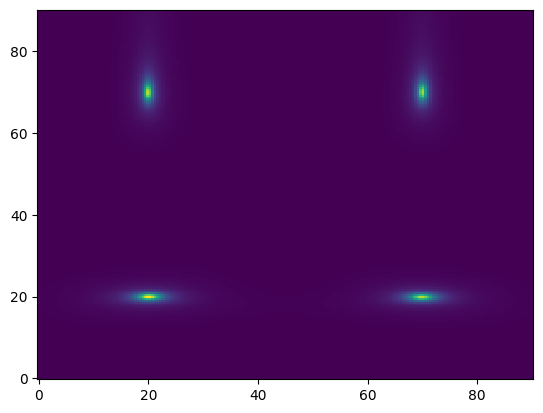

In [5]:
# Simulation parameters
el = [20, 20, 70, 70]
az = [20, 70, 20, 70]
Lx = 10
Ly = 10
N = 100
SNR_dB = 5

# Synthesize signal with noise
x, r = get_URA(el, az, Lx, Ly, N)
x += get_noise(x, SNR_dB)

# Estimate number of impinging waves
M_est = len(el)

# Run MUSIC beamformer
Pm, el_search, az_search = MUSIC_2D(x, r, M_est)

# Plot
fig, ax = plt.subplots()
ax.pcolormesh(el_search, az_search, np.abs(Pm))